In [1]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
import pyqmc
import scipy
import matplotlib.pyplot as plt
from pyscf.scf.hf import dump_scf_summary
from concurrent.futures import ProcessPoolExecutor
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [2]:
# H2 molecule
def run_scf(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.;H 0. 0. 1.;", basis=f'ccecpccpvdz', unit='bohr')
    mf = scf.UHF(mol)
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm)
    dump_scf(mf.mol, 'scf.hdf5', mf.energy_tot(), mf.mo_energy, mf.mo_coeff, mf.mo_occ)
    return mf

def run_lda_be(scf_checkfile):
    print("Be atom neutral LDA spin=2")
    mol = gto.M(atom="Be 0. 0. 0.", spin=2,basis=f'ccpvdz', unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")        
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_li(scf_checkfile):
    print("Li atom neutral LDA spin=1")
    mol = gto.M(atom="Li 0. 0. 0.",basis=f'ccpvtz', spin=1, unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_he(scf_checkfile):
    print("He atom neutral LDA spin=0")
    # mol = gto.M(atom="He 0. 0. 0.", basis="ccECP_cc-pVDZ", ecp="ccecp", unit='bohr')
    mol = gto.M(atom="He 0. 0. 0.", basis="ccpvdz", unit='bohr')    
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_h2(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 2", spin = 2, basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.xc='LDA, VWN'
    mf.kernel()    
    # mf.kernel(dm, xc='LDA,VWN')
    return mf

def run_lda(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.", spin=1,basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf
    
def run_casscf(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASSCF(mf,2,2)
    mc.chkfile = ci_checkfile
    mc.kernel()
    with h5py.File(mc.chkfile, "a") as f:
        print("Available output from CASSCF:", f["mcscf"].keys())
        f["mcscf/nelecas"] = list(mc.nelecas)
        f["mcscf/ci"] = mc.ci
    return mc

def run_casci(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    # ncas: orbitals
    # nelecas: electrons
    ncas = 5
    nelecas = 2
    mc = mcscf.CASCI(mf, ncas, nelecas)
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff
        print("Available output from CASCI:", f["ci"].keys())
    return mc

def make_wf_object(scf_checkfile, ci_checkfile):
    mol, mf, mc = pyq.recover_pyscf(scf_checkfile, ci_checkfile=ci_checkfile)
    wf, _ = pyq.generate_wf(mol, mf, mc=mc)
    return wf

def stat_qmc(etot, filename):
    block_sizes = np.linspace(2,len(etot[discard:])//16, 10, dtype=int)
    reblocks = [len(etot)//s for s in block_sizes]

    plt.figure()
    df = pd.DataFrame([pyq.read_mc_output(filename, warmup=discard, reblock=reblock) for reblock in reblocks])
    df['block_size'] = block_sizes
    plt.plot("block_size",'energytotal_err',data=df, marker='o')
    plt.xlabel("Block size")
    plt.ylabel("Estimated uncertainty (Ha)")

def reblock(e, discard, reblock_size):
    e = e[discard:]
    vals = pyqmc.reblock.reblock(e,int(len(e)/reblock_size))
    # import pdb
    # pdb.set_trace()
    
    e_m  = np.mean(vals, axis=0)
    e_d  = scipy.stats.sem(vals, axis=0)    
    return e, e_m, e_d

for fname in ['scf.hdf5','ci.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)   
        
scf_checkfile = "scf.hdf5"
ci_checkfile = "ci.hdf5"
# mf = run_scf(scf_checkfile)
mf_lda = run_lda_he(scf_checkfile)
mcc = run_casci(scf_checkfile, ci_checkfile)

He atom neutral LDA spin=0
HF
converged SCF energy = -2.85516047724274  <S^2> = 0  2S+1 = 1
LDA
converged SCF energy = -2.82670655418611  <S^2> = 4.4408921e-16  2S+1 = 1
CASCI E = -2.88759483109094  E(CI) = -2.88759483109094  S^2 = 0.0000000
dict_keys(['mol', '_scf', 'verbose', 'stdout', 'max_memory', 'ncas', 'nelecas', '_ncore', 'fcisolver', 'frozen', 'extrasym', 'e_tot', 'e_cas', 'ci', 'mo_coeff', 'mo_energy', 'mo_occ', 'converged'])
Available output from CASCI: <KeysViewHDF5 ['ci', 'mo_coeff', 'ncas', 'nelecas']>


In [32]:
tstep = 0.1
nconfig = 200
nblocks = 1000
nsteps_per_block = 4
discard = 100

In [ ]:
#ABVMC
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)

from recipes import ABDMC, DMC, ABVMC, VMC
tstep = 0.01
nconfig = 1000
nblocks = 500
nsteps_per_block = 4
discard = 10
reblock_size = 10

#Timestep error tests
t = [0.3, 0.1, 0.01, 0.001]
e_t_abvmc = []
e_t_abvmc_err = []
ab_e_dict = {}
ab_acc_dict = {}
for dt in t:
    for fname in ['abvmc-ci.hdf5']:
        if os.path.isfile(fname):
            os.remove(fname)    
    ABVMC("scf.hdf5", "abvmc-ci.hdf5", 
          verbose=True, 
          ci_checkfile="ci.hdf5",
          tstep=dt, 
          nconfig=nconfig,
          nblocks=nblocks,
          nsteps_per_block=nsteps_per_block,
          seed=100
         )
    with h5py.File("abvmc-ci.hdf5") as f:
        etot_t = f['energytotal'][...] 
        acc = f['acceptance'][...] 
    ab_e_dict[dt]=etot_t
    ab_acc_dict[dt]=acc
    for e in [etot_t]:
        e_m = np.mean(e[dt_discard:])
        e_d = np.var(e[dt_discard:])
        
        e_t_abvmc.append(e_m)
        e_t_abvmc_err.append(e_d)



Using spherical guess
-> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/bosonwf.py(157)recompute()
    155             import pdb
    156             pdb.set_trace()
--> 157             if is_zero > 0 and zero_pct > 0.01:
    158                 warnings.warn(
    159                     f"A wave function is zero. Found this proportion: {is_zero/nconf}"



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/bosonwf.py(157)recompute()
    155             import pdb
    156             pdb.set_trace()
--> 157             if is_zero > 0 and zero_pct > 0.01:
    158                 warnings.warn(
    159                     f"A wave function is zero. Found this proportion: {is_zero/nconf}"



Text(0, 0.5, 'Energy (Ha)')

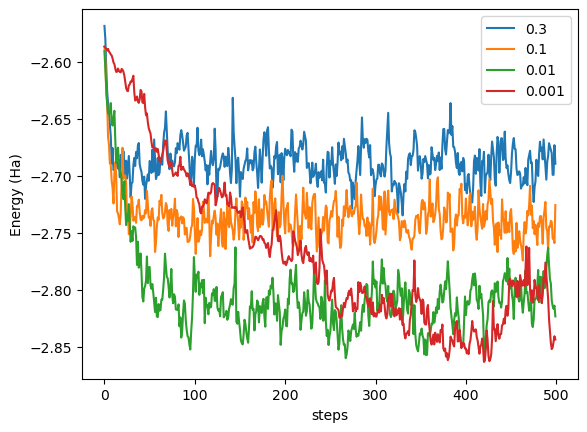

In [68]:
for i in t:
    plt.plot(ab_e_dict[i], label=str(i))
plt.legend()
plt.xlabel('steps')
plt.ylabel('Energy (Ha)')

Text(0, 0.5, 'Acceptance (Ha)')

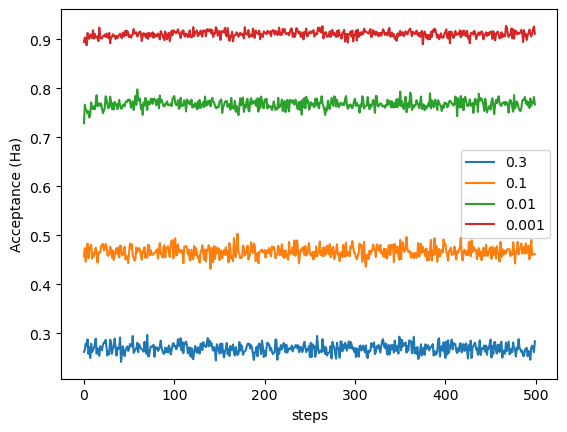

In [69]:
for i in t:
    plt.plot(ab_acc_dict[i], label=str(i))
plt.legend()
plt.xlabel('steps')
plt.ylabel('Acceptance (Ha)')

In [59]:
f.keys()

<KeysViewHDF5 ['acceptance', 'block', 'configs', 'energycorr', 'energyee', 'energyei', 'energyii', 'energyka', 'energykb', 'energyke', 'energytotal', 'energyvh', 'energyvxc', 'nconfig']>

In [39]:
#VMC
#
#
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)

for fname in ['vmc.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)

from recipes import ABDMC, DMC, ABVMC, VMC
tstep = 0.01
nconfig = 123
nblocks = 100
nsteps_per_block = 4

discard = 10
reblock_size = 10

#Timestep error tests
t = [1, 0.3, 0.1, 0.01, 0.001]
e_t_abvmc = []
e_t_abvmc_err = []
e_dict = {}
for dt in t:
    for fname in ['vmc-ci.hdf5']:
        if os.path.isfile(fname):
            os.remove(fname)    
    dt_steps = int(nblocks*nsteps_per_block*tstep/dt)
    dt_steps = 100 if dt_steps < 1000 else dt_steps
    dt_steps = 2000 if dt_steps > 2000 else dt_steps 
    dt_discard = int(dt_steps/2)
    print(dt_steps, dt_discard)
    VMC("scf.hdf5", "vmc-ci.hdf5", verbose=True, 
        ci_checkfile='ci.hdf5',
        tstep=dt, 
        nconfig=nconfig,     
        nblocks=nblocks,
        nsteps_per_block=nsteps_per_block,
        seed=100
       )
    with h5py.File("vmc-ci.hdf5") as f:
        etot_t = f['energytotal'][...] 
        
    e_dict[dt]=etot_t
    for e in [etot_t]:
        e_m = np.mean(e[dt_discard:])
        e_d = np.var(e[dt_discard:])
        e_t_abvmc.append(e_m)
        e_t_abvmc_err.append(e_d)



100 50
Number of determinants in the Fermionic wavefunction= 25
-> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/slater.py(193)recompute()
    191             import pdb
    192             pdb.set_trace()
--> 193             self._dets.append(
    194                 gpu.cp.asarray(np.linalg.slogdet(mo_vals))
    195             )  # Spin, (sign, val), nconf, [ndet_up, ndet_dn]



ipdb>  mo_vals.shape


(123, 5, 1, 1)


ipdb>  aa=np.linalg.slogdet(mo_vals)
ipdb>  aa.shape


*** AttributeError: 'tuple' object has no attribute 'shape'


ipdb>  aa[0].shape


(123, 5)


ipdb>  aa[1].shape


(123, 5)


ipdb>  exit


Text(0, 0.5, 'Energy (Ha)')

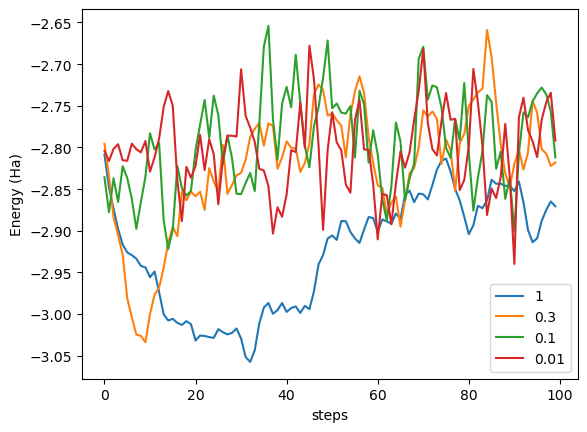

In [27]:
for i in t:
    plt.plot(e_dict[i], label=str(i))
plt.legend()
plt.xlabel('steps')
plt.ylabel('Energy (Ha)')

'/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyqmc/__init__.py'

In [30]:
#VMC base
#
#
import pyqmc
print(pyqmc.__file__)
tstep = 0.01
nconfig = 1000
nblocks = 100
nsteps_per_block = 4
discard = 10
reblock_size = 10

#Timestep error tests
t = [1, 0.3, 0.1, 0.01]
e_t_vmc_base = []
e_t_vmc_base_err = []
e_dict_base = {}
for dt in t:
    for fname in ['vmc-base.hdf5']:
        if os.path.isfile(fname):
            os.remove(fname)    
    dt_steps = int(nblocks*nsteps_per_block*tstep/dt)
    dt_steps = 100 if dt_steps < 1000 else dt_steps
    dt_steps = 200 if dt_steps > 2000 else dt_steps 
    dt_discard = int(dt_steps/2)
    print(dt_steps, dt_discard)
    pyqmc.recipes.VMC("scf.hdf5", "vmc-base.hdf5", verbose=True, 
                      nsteps =dt_steps, 
                      tstep=dt, 
                      nconfig=nconfig,     
                      nblocks=nblocks,
                      nsteps_per_block=nsteps_per_block)
    with h5py.File("vmc-base.hdf5") as f:
        etot_t = f['energytotal'][...] 
    e_dict_base[dt]=etot_t
    for e in [etot_t]:
        e_m = np.mean(e[dt_discard:])
        e_d = np.var(e[dt_discard:])
        e_t_vmc_base.append(e_m)
        e_t_vmc_base_err.append(e_d)



/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyqmc/__init__.py
100 50
----------------------------------------------------------------------------------------------------vmc done
100 50
----------------------------------------------------------------------------------------------------vmc done
100 50
----------------------------------------------------------------------------------------------------vmc done
100 50
----------------------------------------------------------------------------------------------------vmc done


Text(0, 0.5, 'Energy (Ha)')

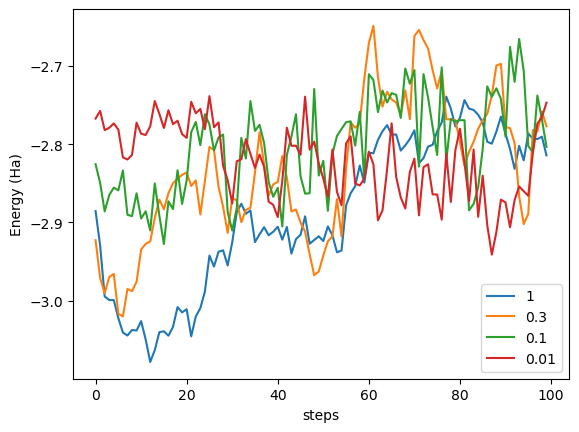

In [31]:
for i in t:
    plt.plot(e_dict_base[i], label=str(i))
plt.legend()
plt.xlabel('steps')
plt.ylabel('Energy (Ha)')